# 🧠 Neural Networks from Scratch

**Goal:** By the end of this notebook, you will understand exactly what happens when someone says *"the model is training."* No magic, no hand-waving.

### We'll build a neural network using only NumPy (basic math), train it to solve a problem that a single neuron cannot solve, and then see how PyTorch automates what we did manually.

---

## What We'll Cover

- The XOR Problem — Why we need hidden layers
- Building a Neural Network — Forward pass from scratch
- The Training Loop — Loss, backprop, weight updates
- Watching It Learn — Visualizing training
- Breaking It — What happens with bad hyperparameters
- PyTorch Version — Same thing, less code

---

## Let's go 🚀


# Part 1: The XOR Problem

## Why XOR?

XOR (exclusive or) is a simple logical operation:
- If inputs are **different** → output 1
- If inputs are **the same** → output 0

| Input A | Input B | Output |
|---------|---------|--------|
| 0       | 0       | 0      |
| 0       | 1       | 1      |
| 1       | 0       | 1      |
| 1       | 1       | 0      |

### The Historical Importance

In 1969, Minsky and Papert proved that a single-layer perceptron (one neuron)
**cannot learn XOR**. This caused the first "AI Winter" — people thought neural
networks were fundamentally limited.

The solution? **Hidden layers.** A network with at least one hidden layer CAN
learn XOR. This notebook proves it.


In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
#our training data: XOR
X = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

y = np.array([
    [0],
    [1],
    [1],
    [0]
])

In [16]:
print("XOR Dataset:")
print("-"*30)
for i in range(len(X)):
    print(f"Input: {X[i]} → Output: {y[i][0]}")

XOR Dataset:
------------------------------
Input: [0 0] → Output: 0
Input: [0 1] → Output: 1
Input: [1 0] → Output: 1
Input: [1 1] → Output: 0


Visualizing the Problem
Let's plot the XOR data. You'll see why a straight line can't separate the classes.

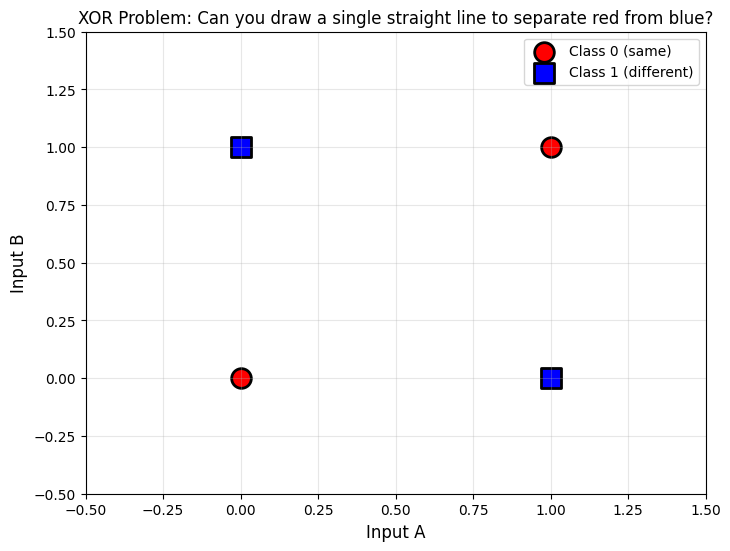


❌ A single straight line CANNOT separate these classes.
✅ This is why we need hidden layers — they create non-linear boundaries.


In [23]:
plt.figure(figsize=(8, 6))
#plot the points
for i in range(len(X)):
    color="red" if y[i][0]==0 else "blue"
    marker= 'o' if y[i][0]==0 else "s"
    plt.scatter(X[i][0],X[i][1],c=color,s=200,marker=marker,edgecolors="black",linewidth=2)
    plt.xlabel('Input A', fontsize=12)
plt.ylabel('Input B', fontsize=12)
plt.title('XOR Problem: Can you draw a single straight line to separate red from blue?',
          fontsize=12)
plt.grid(True, alpha=0.3)

plt.xlim(-0.5,1.5)
plt.ylim(-0.5,1.5)
plt.legend(['Class 0 (same)', 'Class 1 (different)'], loc='upper right')
plt.show()

print("\n❌ A single straight line CANNOT separate these classes.")
print("✅ This is why we need hidden layers — they create non-linear boundaries.")